# Final Model (Classwise/Y Scaling) with XGBoost

In [1]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from joblib import dump, load

In [2]:
W=35
L=8
T=25
test_df = pd.read_csv('./test_data/W35L8T25.csv')
test_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,2.628500e-13,35,8,25
1,0.1,-19.8,2.628500e-13,35,8,25
2,0.1,-19.6,2.628500e-13,35,8,25
3,0.1,-19.4,2.628500e-13,35,8,25
4,0.1,-19.2,2.628500e-13,35,8,25


In [3]:
vgs_list = test_df['Vgs'].unique()
len(vgs_list)
vds_list = test_df['Vds'].unique()
len(vds_list)

6

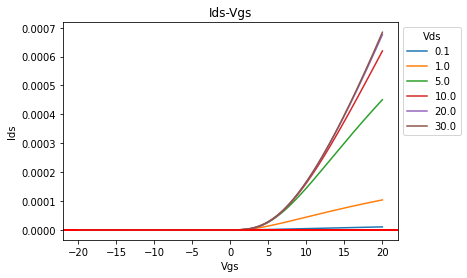

In [4]:
for vds in vds_list:
    plt.plot(test_df.query('Vds=='+str(vds))['Vgs'], test_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

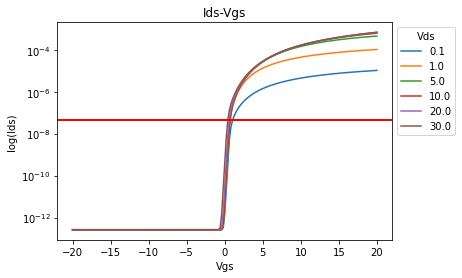

In [5]:
for vds in vds_list:
    plt.plot(test_df.query('Vds=='+str(vds))['Vgs'], test_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

In [6]:
class_0_df = test_df.query('Vgs<0')
class_1_df = test_df.query('Vgs>=0')

In [7]:
class_0_model = xgboost.XGBRegressor()
class_0_model.load_model('./checkpoints/class_scale_xgboost_class_0.model')
class_1_model = xgboost.XGBRegressor()
class_1_model.load_model('./checkpoints/class_scale_xgboost_class_1.model')

In [8]:
class_0_X = class_0_df[['W','L','T','Vgs','Vds']].to_numpy()
scaler_0_X = load('./scalers/class_scale_xbgoost_class_0_std_scaler.bin')
class_0_X = scaler_0_X.transform(class_0_X)
class_0_y = class_0_df[['Ids']].to_numpy()

class_1_X = class_1_df[['W','L','T','Vgs','Vds']].to_numpy()
scaler_1_X = load('./scalers/class_scale_xbgoost_class_1_std_scaler.bin')
class_1_X = scaler_1_X.transform(class_1_X)
class_1_y = class_1_df[['Ids']].to_numpy()

In [9]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((log_abs_delta/(log_abs_y+eps))**2)) + np.sqrt((1/len_delta)*np.sum((delta/(y+eps))**2))

In [10]:
def NRMSELoss_0(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((log_abs_delta/(log_abs_y+eps))**2))

In [11]:
def NRMSELoss_1(y_hat, y, eps=1e-8):
    log_abs_y_hat = np.log(np.abs(y_hat)+eps)
    log_abs_y = np.log(np.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = len(y_hat)
    return np.sqrt((1/len_delta)*np.sum((delta/(y+eps))**2))

In [12]:
class_0_pred = class_0_model.predict(class_0_X)
class_0_pred = np.exp(class_0_pred)
class_0_y = class_0_y.flatten()
class_0_nrmse_0 = NRMSELoss_0(class_0_pred, class_0_y)
class_0_nrmse_1 = NRMSELoss_1(class_0_pred, class_0_y)
class_0_nrmse = NRMSELoss(class_0_pred, class_0_y)
print(class_0_nrmse)
print(class_0_nrmse_0)
print(class_0_nrmse_1)

0.0006519924489038175
3.388223204722452e-05
0.0006181102168565931


In [13]:
class_1_pred = class_1_model.predict(class_1_X)
class_1_pred = np.exp(class_1_pred)
class_1_y = class_1_y.flatten()
class_1_nrmse_0 = NRMSELoss_0(class_1_pred, class_1_y)
class_1_nrmse_1 = NRMSELoss_1(class_1_pred, class_1_y)
class_1_nrmse = NRMSELoss(class_1_pred, class_1_y)
print(class_1_nrmse)
print(class_1_nrmse_0)
print(class_1_nrmse_1)

0.04718182593551175
0.0038832681858760043
0.043298557749635744


In [14]:
total_pred = np.concatenate((class_0_pred, class_1_pred), axis=None)
total_y = np.concatenate((class_0_y, class_1_y), axis=None)
total_nrmse_0 = NRMSELoss_0(total_pred, total_y)
total_nrmse_1 = NRMSELoss_1(total_pred, total_y)
total_nrmse = NRMSELoss(total_pred, total_y)
print('Total NRMSE: ', total_nrmse)
print('NRMSE (Type0): ', total_nrmse_0)
print('NRMSE (Type1): ', total_nrmse_1)

Total NRMSE:  0.03328274226431959
NRMSE (Type0):  0.002739151490903752
NRMSE (Type1):  0.03054359077341584


In [15]:
class_0_df.insert(3, 'Pred_Ids', class_0_pred)
print(class_0_df)

       Vds           Vgs           Ids      Pred_Ids   W  L   T
0      0.1 -2.000000e+01  2.628500e-13  2.628804e-13  35  8  25
1      0.1 -1.980000e+01  2.628500e-13  2.628804e-13  35  8  25
2      0.1 -1.960000e+01  2.628500e-13  2.628804e-13  35  8  25
3      0.1 -1.940000e+01  2.628500e-13  2.628804e-13  35  8  25
4      0.1 -1.920000e+01  2.628500e-13  2.628804e-13  35  8  25
...    ...           ...           ...           ...  .. ..  ..
1101  30.0 -8.000000e-01  2.725500e-13  2.456220e-13  35  8  25
1102  30.0 -6.000000e-01  3.429300e-13  3.603959e-13  35  8  25
1103  30.0 -4.000000e-01  1.599400e-12  9.227975e-13  35  8  25
1104  30.0 -2.000000e-01  2.411900e-11  9.215860e-12  35  8  25
1105  30.0 -3.758100e-14  4.243700e-10  2.671189e-10  35  8  25

[606 rows x 7 columns]


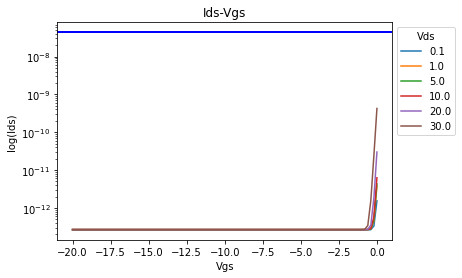

In [16]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

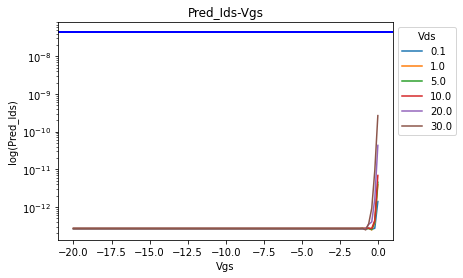

In [17]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [18]:
class_1_df.insert(3, 'Pred_Ids', class_1_pred)
print(class_1_df)

       Vds   Vgs           Ids      Pred_Ids   W  L   T
101    0.1   0.2  2.349200e-11  2.277561e-11  35  8  25
102    0.1   0.4  4.073900e-10  4.505167e-10  35  8  25
103    0.1   0.6  4.861400e-09  4.893898e-09  35  8  25
104    0.1   0.8  1.962100e-08  1.763877e-08  35  8  25
105    0.1   1.0  4.056000e-08  3.906143e-08  35  8  25
...    ...   ...           ...           ...  .. ..  ..
1201  30.0  19.2  6.359800e-04  6.240348e-04  35  8  25
1202  30.0  19.4  6.479800e-04  6.339490e-04  35  8  25
1203  30.0  19.6  6.600400e-04  6.544449e-04  35  8  25
1204  30.0  19.8  6.721500e-04  6.655867e-04  35  8  25
1205  30.0  20.0  6.843100e-04  6.770250e-04  35  8  25

[600 rows x 7 columns]


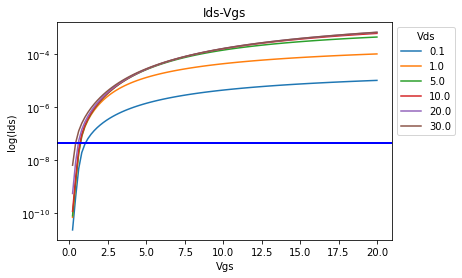

In [19]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

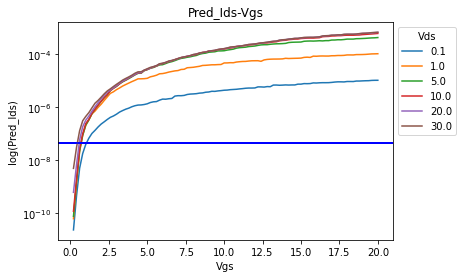

In [20]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [21]:
merged_df = pd.concat([class_0_df, class_1_df])
print(merged_df)

       Vds   Vgs           Ids      Pred_Ids   W  L   T
0      0.1 -20.0  2.628500e-13  2.628804e-13  35  8  25
1      0.1 -19.8  2.628500e-13  2.628804e-13  35  8  25
2      0.1 -19.6  2.628500e-13  2.628804e-13  35  8  25
3      0.1 -19.4  2.628500e-13  2.628804e-13  35  8  25
4      0.1 -19.2  2.628500e-13  2.628804e-13  35  8  25
...    ...   ...           ...           ...  .. ..  ..
1201  30.0  19.2  6.359800e-04  6.240348e-04  35  8  25
1202  30.0  19.4  6.479800e-04  6.339490e-04  35  8  25
1203  30.0  19.6  6.600400e-04  6.544449e-04  35  8  25
1204  30.0  19.8  6.721500e-04  6.655867e-04  35  8  25
1205  30.0  20.0  6.843100e-04  6.770250e-04  35  8  25

[1206 rows x 7 columns]


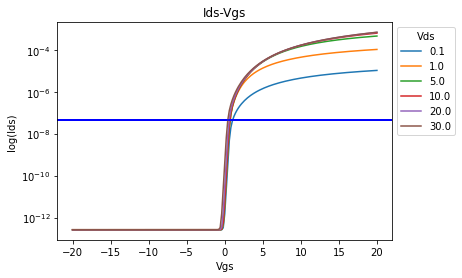

In [22]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

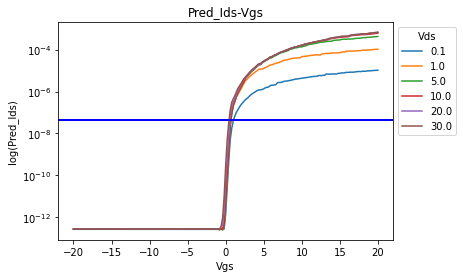

In [23]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('log(Pred_Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

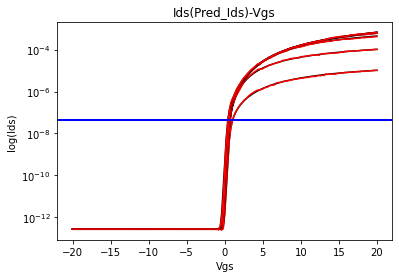

In [24]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Ids'], label=vds, color='black')
    plt.plot(merged_df.query('Vds=='+str(vds))['Vgs'], merged_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds, color='red')
    plt.xlabel('Vgs')
    plt.ylabel('log(Ids)')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'b', linestyle = '-')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids(Pred_Ids)-Vgs')

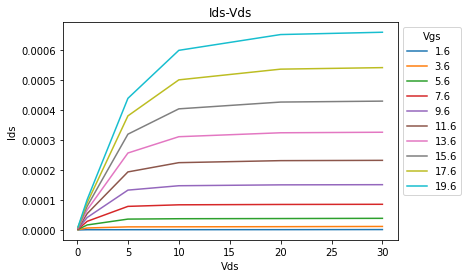

In [25]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Ids'], label=vgs)
    plt.xlabel('Vds')
    plt.ylabel('Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Ids-Vds')

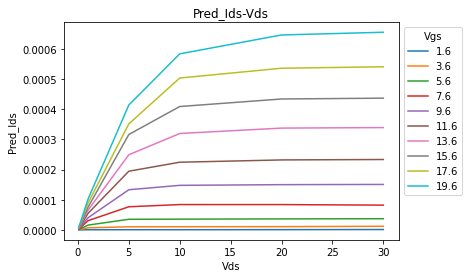

In [26]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Pred_Ids'], label=vgs)
    plt.xlabel('Vds')
    plt.ylabel('Pred_Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Pred_Ids-Vds')

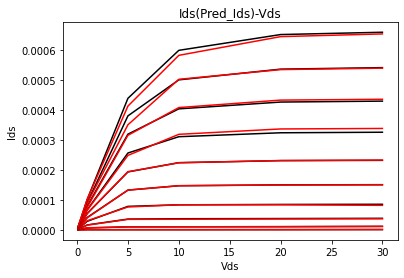

In [27]:
vgs_list = merged_df['Vgs'].unique()
len(vgs_list)
vds_list = merged_df['Vds'].unique()
len(vds_list)
vgs_list = [(i+1.6) for i in range(0, 20, 2)]
for vgs in vgs_list:
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Ids'], label=vgs, color='black')
    plt.plot(merged_df.query('Vgs=='+str(vgs))['Vds'], merged_df.query('Vgs=='+str(vgs))['Pred_Ids'], label=vgs, color='red')
    plt.xlabel('Vds')
    plt.ylabel('Ids')
    # plt.yscale('log')
    # plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    # plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vgs')
    plt.title('Ids(Pred_Ids)-Vds')